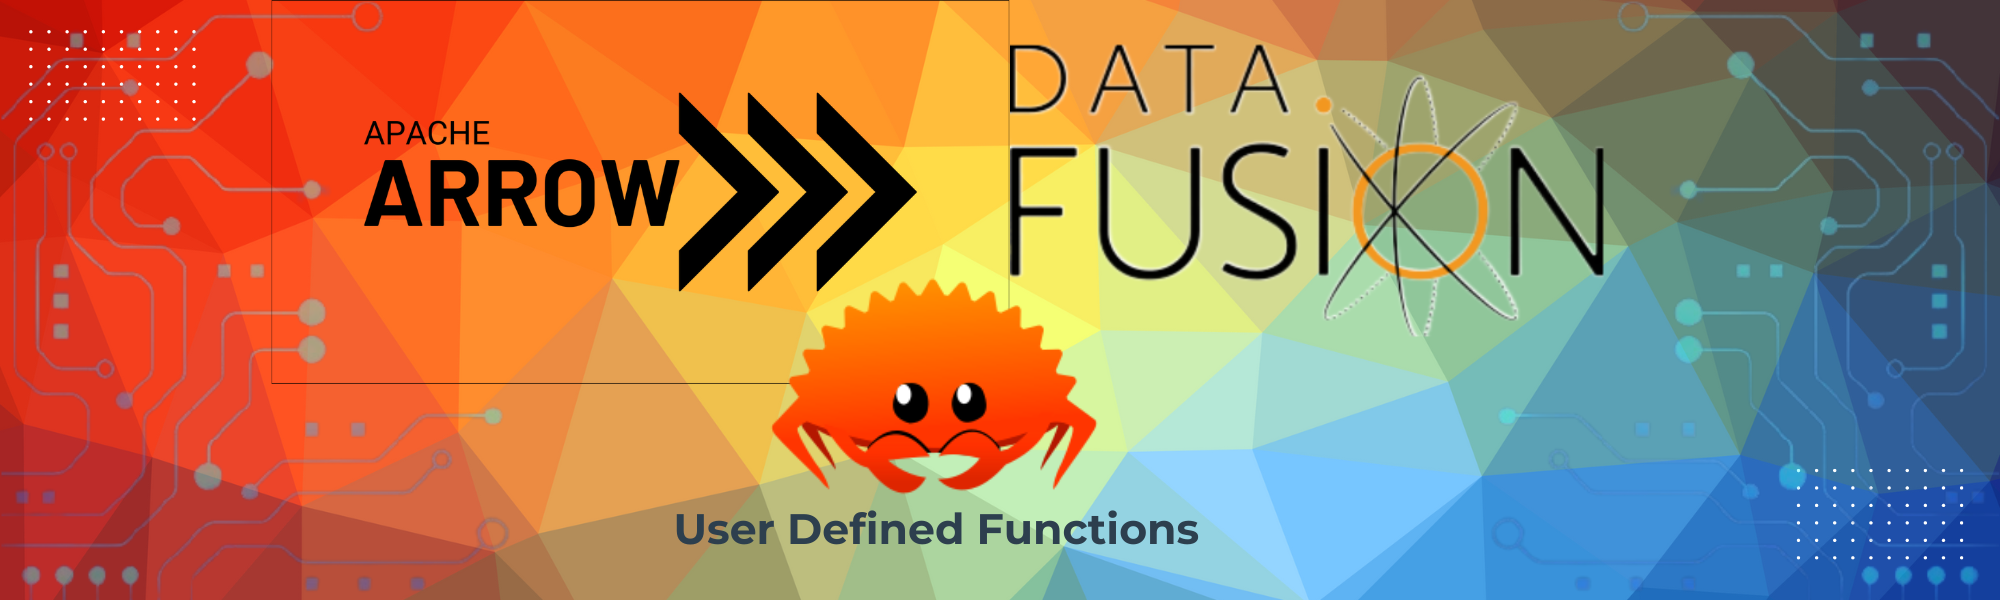

## Setup Preambles

This notebook uses [Evcxr Jupyter Kernel](https://github.com/evcxr/evcxr/blob/main/evcxr_jupyter/README.md) A Jupyter Kernel for the Rust programming language. It makes it possible to execute Rust code within Jupter notebook. To install, follow the steps:

1. Install by running `cargo install evcxr_jupyter`
2. Register the kernel with Jupyter by running `evcxr_jupyter --install`
3. Start Jupyter notebook by running `jupyter notebook`
4. Juypter notebook will open a new browser. Switch to Rust by clicking on "New" menu on the right and from it, select "Rust"
5. Download the notebook [here](https://github.com/dadepo/blogposts/blob/master/2023-04-17_a-guide-to-user-defined-functions-in-apache-arrow-datafusion/A%20Guide%20to%20User-Defined%20Functions%20in%20Apache%20Arrow%20DataFusion.ipynb). Then load into Juyper via `File -> Open ...` and  navigate to the `.ipnyb` file

### A Guide to User-Defined Functions in Apache Arrow DataFusion

Data processing is an essential part of modern-day software development, and Apache Arrow has emerged as a powerful tool in the toolbox for efficient data processing. 

Apache Arrow is a cross-language development platform for in-memory data that enables high-performance communication between different systems, languages, and processes. With Arrow, developers can easily move data between different applications and perform operations on that data in a fast and efficient manner.


### Apache Arrow and Columnar Data Layout

At the heart of Apache Arrow's power is its columnar nature, which enables it to handle large volumes of data with great speed and efficiency. In contrast to traditional row-oriented data storage, which stores data in rows and requires expensive operations to retrieve specific columns, columnar storage stores data in columns, making it easy to access and process specific subsets of data. 

The illustration below shows how records from database tables are typically stored into disk blocks in row-oriented data storage system

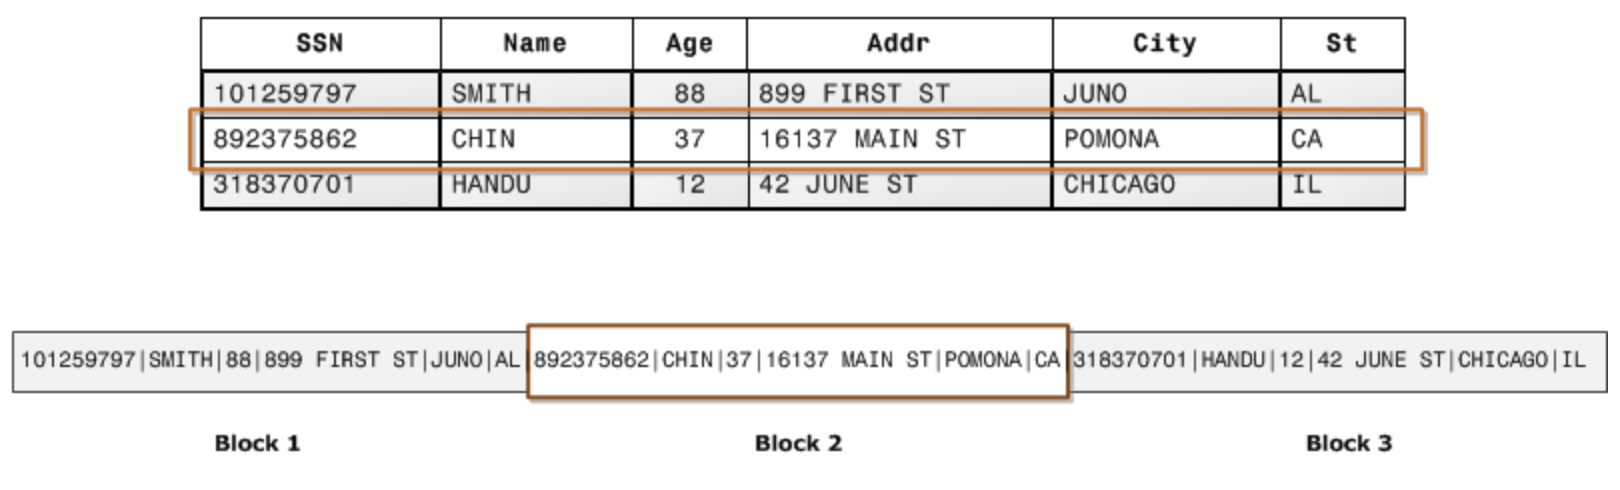

As can be seen, each row of data is saved in contigous memory blocks, placed one after the other. This is how data is stored in row based storage systems.

The next illustration, on the other hand, shows how same records will be stored in columnar data storage systems

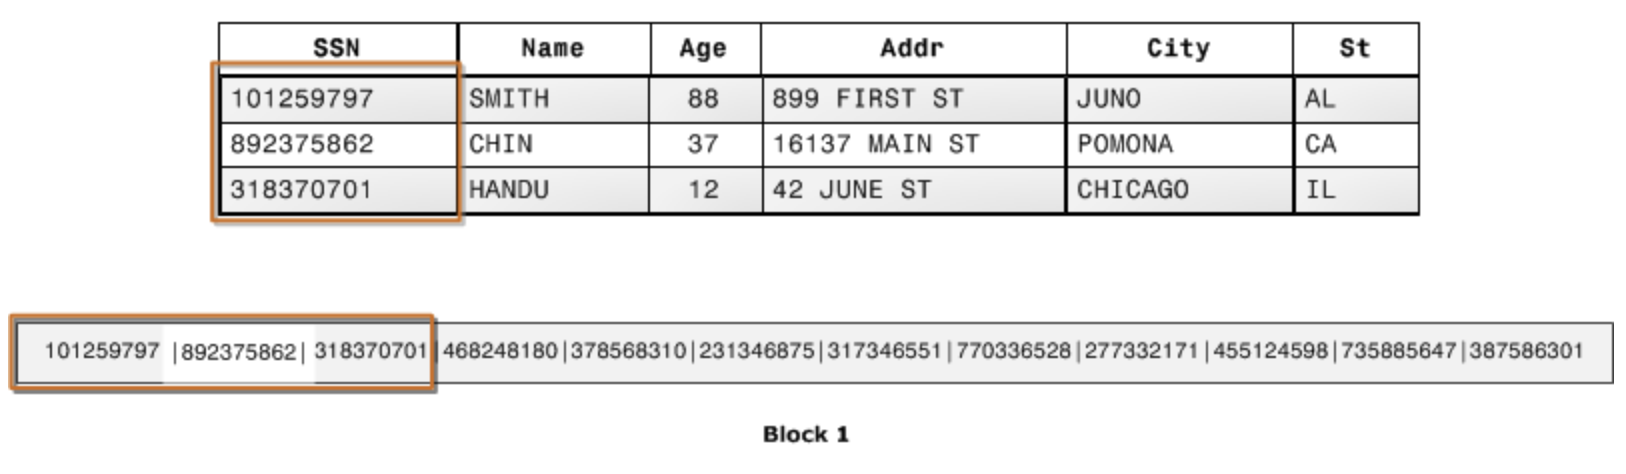

In the case of columnar data storage, values from each columns are saved in contigous memory blocks, placed one after the other.

Since Apache Arrow is concerned with how data is layed out in memory, and not how data is stored on disk, it's use of  columnar orientation dictates how data is saved in memory for processing. 

This has several advantages, including better compression, faster query performance, and improved analytics capabilities. By storing data in a columnar format, compression algorithms can be applied more efficiently, resulting in higher compression ratios and reduced storage costs.

Columnar layouts are also more efficient for analytics workloads, as they allow for vectorized processing of data. This means that operations can be applied to entire columns at once, rather than row-by-row, resulting in significant performance improvements. Moreover, modern CPUs are designed to take advantage of SIMD (Single Instruction, Multiple Data) instructions, which are well-suited to vectorized processing of data in columnar formats.

Finally, columnar layouts are more flexible and extensible than row-based layouts, as each column can be stored independently. This makes it easier to add or remove columns from a table, or to modify the data types of existing columns. Additionally, columnar layouts are well-suited to parallel and distributed computing, allowing them to scale to handle large and complex datasets.

#### DataFusion a Fast, Extensible Query Engine 

Apache DataFusion is an open-source library written in Rust for executing queries on Apache Arrow-based data sources. It is a query engine that can execute queries across multiple data sources, including CSV files, Parquet files, and more. Queries can be written using either SQL or via a DataFrame API.

While Datafusion provides a powerful query engine for executing SQL queries, there may be situations where a specific operation or transformation is not directly supported by the built-in SQL functions. In such cases, user-defined functions (UDFs) can be a powerful tool for data engineers and data scientists to extend the functionality of Datafusion and perform custom operations on their data. By defining their own UDFs, users can tailor Datafusion's query engine to their specific needs and achieve greater flexibility and control over their data processing pipeline. 

In this post, we'll explore how to define and use UDFs in DataFusion to enable customized data processing.


#### Arrays in Apache Arrow

Before diving into how to create and use UDFs in Datafusion, it's important to have some understanding of the Arrow's Array's since the data that Datafusion operates will be handed over to our UDF's as Apache Arrow's Arrays.

Arrow defines a set of primitive and composite data types that are used to represent data in-memory across different systems and programming languages. These category of data types include Scalar, Arrays, ChunkedArrays, RecordBatch, Table, and Dataset. This post will only look at Arrays since that is what we will be operating on, but to learn more about the other data types consult [Arrow Columnar Format Specification](https://arrow.apache.org/docs/format/Columnar.html)

Arrays in Apache Arrow are a collection of values of the same data type, represented as a contiguous block of memory. For example, a BooleanArray might represent a sequence of true/false values, while an Int64Array might represent a sequence of 64-bit integers. You can think of Apache's Arrays as the fundamental data structure used to represent columnar data. The Array data types and functionality are implemented in [arrow-array](https://docs.rs/arrow-array/37.0.0/arrow_array/index.html) crate. DataFusion makes use of this crate and values passed into our UDF will be of Array types.

With the preambles out of the way, we talk next about the functionality we want to implement as UDFs and show the implementation on how to go about it




#### Getting Broadcast Address with DataFusion's User Defined Function

To demonstrate how user-defined functions can be implemented, we will use a sample dataset of IP address prefixes that have been announced by different autonomous systems. This dataset contains both IPv4 and IPv6 addresses and is similar to data that can be retrieved from [RIPE Stats](https://stat.ripe.net/about/) tool. Our goal will be to write user-defined functions that can extract the broadcast addresses from these IP addresses, and use them to perform further analysis and calculations.

The sample CSV we will be using contains this following entries

```
prefix,announced_by,rir
217.165.64.0/18,AS5384,RIPE
172.110.244.0/24,AS11597,ARIN
142.64.0.0/16,AS5769,ARIN
2001:408::/32,AS14793,ARIN
2001:410:2000::/48,AS10965,ARIN
200.0.85.0/24,AS264102,LACNIC
```


##### Septup: Adding Dependencies.

To implement our user-defined functions, we will be using the Datafusion and Arrow libraries for data processing, along with the Tokio asynchronous runtime for handling concurrent tasks. Additionally, we will be using the [IPNet](https://docs.rs/ipnet/latest/ipnet/) library to perform IP address calculations. Therefore, in our Rust project, we will need to include the following dependencies in `Cargo.toml`:

```
datafusion = "22.0.0"
arrow = "37.0.0"
tokio = {version = "1.25.0", features = ["full"] }
ipnet = "2.7.2"
```

If you are following along in this notebook, then run the code in the next cell

In [2]:
:dep datafusion = "22.0.0"
:dep arrow = "37.0.0"
:dep tokio = {version = "1.25.0", features = ["full"] }
:dep ipnet = "2.7.2"

We will need test data to run our user defined functions against. Since we are in a notebook environment, we will generte the data instead of loading a CSV file for example.

The next cell defines the function that we will use to generate sample test data.

In [3]:
use std::sync::Arc;

use datafusion::arrow::array::StringArray;
use datafusion::arrow::datatypes::{DataType, Field, Schema};
use datafusion::arrow::record_batch::RecordBatch;
use datafusion::from_slice::FromSlice;

fn create_record_batch() -> RecordBatch {
    let fields = vec![
        Field::new("prefix", DataType::Utf8, false),
        Field::new("announced_by", DataType::Utf8, false),
        Field::new("rir", DataType::Utf8, false),
    ];

    let schema = Arc::new(Schema::new(fields));

    RecordBatch::try_new(schema, vec![
        Arc::new(StringArray::from_slice(vec![
            "217.165.64.0/18",
            "172.110.244.0/24",
            "142.64.0.0/16",
            "2001:408::/32",
            "2001:410:2000::/48",
            "200.0.85.0/24",
        ])),
        Arc::new(StringArray::from_slice(vec!["AS5384", "AS11597", "AS5769", "AS14793", "AS10965", "AS264102"])),
        Arc::new(StringArray::from_slice(vec!["RIPE", "ARIN", "ARIN", "ARIN", "ARIN", "LACNIC"])),
    ]).unwrap()
}

#### Implementing the UDFs.

We will be implementing a UDF for getting the broadcast address. You can think of this as similar to the [broadcast](https://pgpedia.info/b/broadcast.html) function in PostgreSQL.

The general structure for implementing UDFs in DataFusion involves:

1. Defining a rust function that contains the logic of the UDFs. The function takes and return `ArrayRef` data types
2. DataFusion has its own data types (built on top of Arrow). These are values of type of [ColumnarValue](https://docs.rs/datafusion/latest/datafusion/physical_plan/enum.ColumnarValue.html). For DataFusion to be able to use our function as a UDF, we wrap it in another function that takes care of converting DataFusions values to arrays before calling the function and vice-versa after evaluation.
3. We create the UDF using our wrapped function
4. We register the created UDF with DataFusion
5. Now we can use the UDF in DataFusion


To illustate the above steps, we start with the defining, and registering the _broadcast_ function.
 
Code in the next cell, defined a `broadcast` function

In [4]:
use std::str::FromStr;
use std::sync::Arc;

use datafusion::arrow::array::{ArrayRef, StringArray, UInt8Array};
use datafusion::common::DataFusionError;
use datafusion::error::Result;
use ipnet::IpNet;

// define the logic for the broadcast UDF
pub fn broadcast(args: &[ArrayRef]) -> Result<ArrayRef> {
    if args.len() != 1 {
        return Err(DataFusionError::Internal(format!(
            "broadcast() was called with {} arguments. It requires 1.",
            args.len()
        )));
    }

    let mut result: Vec<String> = vec![];
    let ip_string = datafusion::common::cast::as_string_array(&args[0])?;
    ip_string.iter().flatten().try_for_each(|ip_string| {
        let broadcast_address = IpNet::from_str(ip_string)
            .map_err(|e| DataFusionError::Internal(format!("Parsing {ip_string} failed with error {e}")))?
            .broadcast();
        result.push(broadcast_address.to_string());
        Ok::<(), DataFusionError>(())
    })?;

    Ok(Arc::new(StringArray::from(result)) as ArrayRef)
}

Let us go through the core part of the function. First off, we define the function to take `&[ArrayRef]` as input and returns `Result<ArrayRef>`. 

`ArrayRef` is type alias to `Arc<dyn Array>` that is defined within the `arrow-array` crate. It is a reference-counted reference to a generic arrow `Array`.

The first thing we do is to check that our function is being called with one argument. This is optional but good practice.

Then we move to the core of the implementation, which is basically parsing the input value to their IP number representation and returning the broadcast address. 

One important thing we had to do, is to downcast the `ArrayRef`; a generic `Array` to a `StringArray`, which is no longer generic but represents an array where each element is a variable-sized sequence of bytes representing a string. This is needed to be able to parse the input as strings.

The next thing we need to do to complete the implementation is to wrap the function, turn it into a UDF and then register it with DataFusion. To do this, we define another function that helps with this. The code below is extended to do this.

In [5]:
use std::str::FromStr;
use std::sync::Arc;

use datafusion::arrow::array::{ArrayRef, StringArray, UInt8Array};
use datafusion::arrow::datatypes::DataType;
use datafusion::common::DataFusionError;
use datafusion::error::Result;
use datafusion::logical_expr::{create_udf, Volatility};
use datafusion::physical_expr::functions::make_scalar_function;
use datafusion::prelude::SessionContext;
use ipnet::IpNet;


pub fn register_udfs(ctx: &SessionContext) {
    let broadcast = make_scalar_function(broadcast);
    let broadcast_udf = create_udf(
        "broadcast",
        vec![DataType::Utf8],
        Arc::new(DataType::Utf8),
        Volatility::Immutable,
        broadcast,
    );

    ctx.register_udf(broadcast_udf);
}

Let us go over the newly added function `register_udfs`.

The function takes a reference to `SessionContext` which can be considered as the main interface for executing queries with `DataFusion`. The first thing the function does is to decorate the `broadcast` function by wrapping it with the functionality that converts inputs from Datafusion's data type to Arrow Arrays that it expects. This is done via the `make_scalar_function` function.

The next is to create the actual UDF using the helper function `create_udf`. First argument. `broadcast` is the name we use in registering the UDF and how it will be called. The second and third arguments are the input and output data type of the UDFs. The fourth argument is a bit low level and refers to the functions eligibility for certain optimizations by DataFusion. We set it to `Volatility::Immutable` meaning our UDF will always retuern the same output given the same input. And the fourth argument is the actual function we are turning into a UDF. 

Next we look at how to use the UDF we have defined. To do this, we write a test.

#### Using the broadcast UDF


We have defined a `broadcast` function that contains the core implementation of our UDF. We also define a `register_udfs` that takes care of turning our function into an actual UDF and registering it to a DataFusion `SessionContext`. 

Next we put all of these together by defining a function that use our UDF as shown in the next cell:

In [6]:
use std::str::FromStr;
use std::sync::Arc;

use datafusion::arrow::array::{ArrayRef, StringArray, UInt8Array};
use datafusion::arrow::datatypes::DataType;
use datafusion::common::DataFusionError;
use datafusion::error::Result;
use datafusion::logical_expr::{create_udf, Volatility};
use datafusion::physical_expr::functions::make_scalar_function;
use datafusion::prelude::SessionContext;
use ipnet::IpNet;
use datafusion::error::Result;
use datafusion::prelude::SessionContext;

pub async fn run_udfs() -> Result<()> {
    let ctx = SessionContext::new();
    register_udfs(&ctx);

    let record_batch = create_record_batch();
    ctx.register_batch("data", record_batch)?;
    let df = ctx.sql("select prefix, broadcast(prefix) as broadcast from data").await?;
    
    df.show().await?;

    Ok(())
}

In the `run_udfs` function, we create a DataFusion `SessionContext`, we then pass it to the 
`register_udfs` where the `broadcast` UDF is registered. Then we move on to using the UDF. 

In other to do that, we call the `create_record_batch` function and register the record batch we will be using as test data with the `SessionContext`. 

Then we execute an SQL query where we use the `broadcast` UDF. 

We then call the `show()` method on the Dataframe returned which prints the result to the console.

Running the function will print the following to the console:

```
+--------------------+----------------------------------------+
| prefix             | broadcast                              |
+--------------------+----------------------------------------+
| 217.165.64.0/18    | 217.165.127.255                        |
| 172.110.244.0/24   | 172.110.244.255                        |
| 142.64.0.0/16      | 142.64.255.255                         |
| 2001:408::/32      | 2001:408:ffff:ffff:ffff:ffff:ffff:ffff |
| 2001:410:2000::/48 | 2001:410:2000:ffff:ffff:ffff:ffff:ffff |
| 200.0.85.0/24      | 200.0.85.255                           |
+--------------------+----------------------------------------+
```

In [7]:
run_udfs().await?;

+--------------------+----------------------------------------+
| prefix             | broadcast                              |
+--------------------+----------------------------------------+
| 217.165.64.0/18    | 217.165.127.255                        |
| 172.110.244.0/24   | 172.110.244.255                        |
| 142.64.0.0/16      | 142.64.255.255                         |
| 2001:408::/32      | 2001:408:ffff:ffff:ffff:ffff:ffff:ffff |
| 2001:410:2000::/48 | 2001:410:2000:ffff:ffff:ffff:ffff:ffff |
| 200.0.85.0/24      | 200.0.85.255                           |
+--------------------+----------------------------------------+


The above shows the general procedure to creating, registering and using UDF in DataFusion. 

#### Conclusion


In this blog post, we explored the power of user-defined functions in Datafusion. We explained the columnar data layout and its advantages over row-based layout, such as better cache utilization and improved vectorization through SIMD. We also provided a brief overview of the Array data type in Arrow, which serve as the foundational data types for DataFusion.

We then saw how User-Defined functions (UDFs) in DataFusion is a mechanism for extending the functionality of SQL queries beyond what is provided by default. To demonstrate this we implemented UDFs for getting the broadcast address from IP notation. Other useful UDFs can be implemented. For example, getting the network address or checking if an address is IPv4 or IPv6.